### ZoKrates Benchmarking

#### Functionality:
This notebook benchmarks the gas costs for different .code functions. By setting __max_inputs__ programms with __[1 - max_inputs]__ will be generated.

E.g.
__max_inputs = 3__ will generate the following programms, deploy and execute them, and plot the gas usage for each programm

```
def main(field a):
	 return a

def main(field a, field b):
	 return a, b

def main(field a, field b, field c):
	 return a, b, c
```

#### Requirements for running:
- Geth or similar blockchain client running
- ZoKrates is installed locally (via install script)
- solc is installed globally (npm i -g solc)

#### Running Geth with Istanbul HF:
- Install Geth
- Run:
    ```
    geth --datadir chain init genesis.json
    ```
- Run: 
    ``` 
    geth --port 3000 --networkid 58342 --nodiscover --datadir="chain" --maxpeers=0 --rpc --rpcport 8545 --rpcaddr 127.0.0.1 --rpccorsdomain "*" --rpcapi "eth,net,web3" --nodiscover --allow-insecure-unlock --unlock 0xD51E15b8580D7D1dcBD8FcfD8B712E45807BC305 --password pass --etherbase 0xD51E15b8580D7D1dcBD8FcfD8B712E45807BC305 --mine --minerthreads=1
    ```

#### Generating new Ethereum Account (Optional):
   - Run:
   
    ```
    geth --datadir chain init genesis.json
    ```
   - Replace the alloc address in genesis.json (without 0x prefix) 
   - Run:

    ```
    geth --datadir chain init genesis.json
    ```
   - Replace addresses in 'Running geth command with new address'


### Installing Dependencies:


In [ ]:
import sys
!{sys.executable} -m pip install web3
!{sys.executable} -m pip install matplotlib

### Imports

In [2]:
import json
import matplotlib.pyplot as plt
from web3 import Web3
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8545"))
w3.eth.defaultAccount = w3.eth.accounts[0]

### Set Max Inputs:
Set max number of inputs for the function. proving_scheme only accepts g16 for now, since thats the only available option in the install script version of ZoKrates. Once they are implemented, they can be choosen via provided variable.

In [3]:
max_inputs = 10
proving_scheme = "g16"

### Generate ZoKrates Benchmark files:

In [4]:
# function for naming function parameters with chars. Converts number to char [a-z].
# 1 -> a, 26 -> z, 27 -> za
def name_inputs(num, acc=""):
    if num > 26:
        acc += chr(122)
        return name_inputs(num - 26, acc)
    else:
        return acc + chr(num + 96)

# generates valid ZoKrates functions with given number of inputs
def generate_function(input_num):
    function_name = 'def main('
    function = "\n\t return "
    function_return = " -> (" + "field, " * (input_num - 1) + "field):"
    if input_num == 1:
        function_name = "def main(field a)"
        function = "\n\t return a"
    else:
        for i in range(1, input_num + 1):
            if i != input_num:
                function_name += ('field ' + name_inputs(i) + ', ')
                function += name_inputs(i) + ", "
            else:
                function_name += ('field ' + name_inputs(i) + ')')
                function += name_inputs(i)

    write_files(function_name + function_return + function, input_num)
    
# writes .code files
def write_files(content, input_num):
    file = open(str(input_num) + "-benchmark.zok", "w")
    file.write(content)
    file.close()

# Generates test .code files based on max_input
for i in range(1, max_inputs + 1):
    generate_function(i)
print("Success! Files have been created")




Success! Files have been created


### Compile and deploy

In [ ]:
results_deploy = []
results_verify = []
    
def deploy_and_call():
    data = get_proof() 
    
#   Deploy Contract:
    bytecode = open('verifier_sol_Verifier.bin', 'r').read()
    abi = open('verifier_sol_Verifier.abi', 'r').read()
    contract = w3.eth.contract(abi=abi, bytecode=bytecode)
    tx_hash = contract.constructor().transact()
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    results_deploy.append(tx_receipt.gasUsed)
    contract = w3.eth.contract(address=tx_receipt.contractAddress, abi=abi)
    
#   Call verify function
    tx_hash = contract.functions.verifyTx(data[0], data[1]).transact()
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    results_verify.append(tx_receipt.gasUsed)
    
def get_proof():
    with open('proof.json') as f:
        data = json.load(f)
        f.close()
        return (format_proof(data['proof']), format_inputs(data['inputs'])) 
    
# formats and returns proof data as decimal tuple
def format_proof(proof):
    converted = []
    for key in proof.keys():
        res = []
        converted.append(format_array(proof[key], res))       
    return tuple(converted)

#  convert inputs from hex to decimal
def format_inputs(inputs):
    res = []
    for i in inputs:
        res.append(int(i, 16))
    return res
    
# recursive function for converting the proof data from hex to decimal (needed because of web3.py) while keeping the nested nature of proof data
# only tested for g16 (because the only proof currently available with install script) but should work for any type of scheme
def format_array(arr, res = [], idx = None):
    for elem in arr:
        if type(elem) != list:
            if idx != None:
                res[idx].append(int(elem, 16))
            else:
                res.append(int(elem, 16))
        else:
            res.append([])
            format_array(elem, res, len(res)-1)
    return res
            
for i in range(1, max_inputs + 1):
    params = '3 '* i
    file = str(i) + '-benchmark.zok'
    !zokrates compile -i {i}-benchmark.zok --light
    !zokrates setup -s {proving_scheme} --light
    !zokrates compute-witness -a {params} --light
    !zokrates generate-proof -s {proving_scheme}
    !zokrates export-verifier -s {proving_scheme} -a v2
#   Compiling contract via solc cli
    !solcjs --abi --bin verifier.sol
    deploy_and_call()

print("Results Deploy:")
print(results_deploy)
print("Results Verify:")
print(results_verify)



### Deploy cost of contract

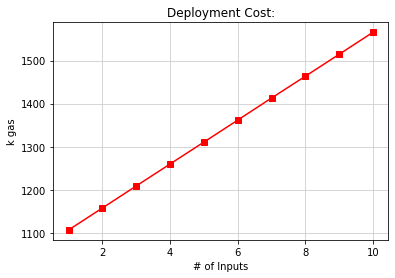

In [8]:
ax = plt.plot(list(range(1, len(results_deploy) + 1)), [x / 1000 for x in results_deploy], '-rs')
plt.title('Deployment Cost:')
plt.xlabel('# of Inputs')
plt.ylabel('k gas')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
plt.savefig('exports/deploy.png')


### Transaction cost of Verification

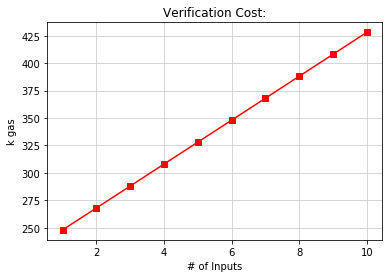

In [7]:
plt.plot(list(range(1, len(results_verify) + 1)), [x / 1000 for x in results_verify], '-rs')
plt.title('Verification Cost:')
plt.xlabel('# of Inputs')
plt.ylabel('k gas')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#cccccc"
plt.savefig('exports/verification.png')